In [2]:
!pip3 install torch torchvision torchaudio

In [4]:
!pip install pytorch-fid

In [8]:
import scipy
from pytorch_fid.inception import InceptionV3

In [9]:
def calculate_activation_statistics(images,batch_size, device):
    dims=2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)
    model.eval()
    act=np.empty((len(images), dims))
    
    images.to(device)
    pred = model(images)[0]

    # If model output is not scalar, apply global spatial average pooling.
    # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [11]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = scipy.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [12]:
def calculate_fretchet(images_real,images_fake):
     mu_1,std_1=calculate_activation_statistics(images_real, batch_size, device)
     mu_2,std_2=calculate_activation_statistics(images_fake, batch_size, device)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [13]:
import os
import glob
from math import floor
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [14]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as utils
from torchvision.models.inception import inception_v3

In [15]:
from torchvision.utils import save_image
from torchvision.utils import make_grid

In [16]:
!pip install pytorch-msssim
from pytorch_msssim import ms_ssim

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
device

'cuda'

In [18]:
def cal_ms_ssim(img_real,img_fake):
  up = nn.Upsample(size=(256,256), mode='bilinear',align_corners=False)
  img_real =up(img_real.type(torch.DoubleTensor))
  img_fake =up(img_fake.type(torch.DoubleTensor))
  
  ms_ssim_score = ms_ssim(img_fake,img_real,data_range=1,size_average=True,channel=3)
  return ms_ssim_score

In [19]:
class LinnaeusDataset(Dataset):
    def __init__(self, all_data_path, transform=None):
        self.all_data_path=all_data_path
        
        self.all_image_paths = list()
        self.all_classes = list()

        for data_path in glob.glob(self.all_data_path + '/*'):
          self.all_classes.append(data_path.split('/')[-1])
          self.all_image_paths.append(glob.glob(data_path + '/*'))

        self.image_paths = list(flatten(self.all_image_paths))
        self.transform = transform

        self.idx_to_class = {i:j for i, j in enumerate(self.all_classes)}
        self.class_to_idx = {value:key for key,value in self.idx_to_class.items()}
        
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = mpimg.imread(image_filepath)
        
        label = image_filepath.split('/')[-2]
        label = self.class_to_idx[label]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [20]:
class ACDiscriminator(nn.Module):
    def __init__(self, nclass):
        super(ACDiscriminator, self).__init__()
      
        self.Cin=3
        self.Cmid=32
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels=self.Cin, out_channels=self.Cmid*2, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                #(32+2-4)/2+1=15+1=16


                nn.Conv2d(in_channels=self.Cmid*2, out_channels=self.Cmid*4, kernel_size=4,stride=2,padding=1),
                nn.BatchNorm2d(self.Cmid*4),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),
                #16+2-4/2+1=8


                nn.Conv2d(in_channels=self.Cmid*4, out_channels=self.Cmid*8, kernel_size=4,stride=2,padding=1),
                nn.BatchNorm2d(self.Cmid*8),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),
                #8+2-4/2+1=4
                

                nn.Conv2d(in_channels=self.Cmid*8, out_channels=self.Cmid*32, kernel_size=4,stride=1,padding=0),
                nn.BatchNorm2d(self.Cmid*32),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                #4+0-4/1+1=1
            )
            
        self.fc_linear = nn.Linear(self.Cmid*32,  256)
        self.fc_class =  nn.Linear(256, nclass)
        self.fc_logsoftmax= nn.LogSoftmax(dim=1)

        self.fc_isreal = nn.Linear(256, 1)
        self.fc_sigmoid= nn.Sigmoid()

    def forward(self, input):
        bz=input.size()[0]
        out = self.conv(input)
        out=out.view(bz,-1)
        
        out = self.fc_linear(out)

        fc_class= self.fc_logsoftmax(self.fc_class(out))
        fc_isreal = self.fc_sigmoid(self.fc_isreal(out))
        
        return fc_class, fc_isreal

In [21]:
class ACGenerator(nn.Module):
    def __init__(self, nz):
        super(ACGenerator, self).__init__()
        self.nz=nz
                
        #linear
        self.fc = nn.Linear(self.nz,512)
        
        self.tconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=4, stride=1,padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 1-4

            nn.ConvTranspose2d(in_channels=256,out_channels=128, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #4->8

            nn.ConvTranspose2d(in_channels=128,out_channels=64, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #8->16

            nn.ConvTranspose2d(in_channels=64,out_channels=3, kernel_size=4, stride=2,padding=1),
            #16->32
            nn.Tanh()
            )
        
        
    def forward(self, input):
        input = input.view(-1,self.nz)
        out = self.fc(input).view(-1,512,1,1)
        out = self.tconv(out)
        
        return out

In [22]:
def training(iterations, dataloader, dis_model, gen_model, optD, optG, class_loss, label_loss,nz, nclass, device):
    fretchet_dist_RF=400
    FID_min=fretchet_dist_RF
    
    for epoch in range(201,iterations+1):
        total_dis_real_loss=0
        total_dis_fake_loss=0
        total_gen_loss=0
        
        total_dis_real_loss_list=list()
        total_dis_fake_loss_list=list()
        total_gen_loss_list=list()
        
        real_image_dis_acc=0
        fake_image_dis_acc=0
        
        for img, img_class in dataloader:            
            img = img.to(device)
            img_class = img_class.to(device)

            #train the discriminator
            optD.zero_grad()

            #real data is 1 and fake data is 0
            real = Variable(torch.ones(img.size()[0],1).to(device))
            fake = Variable(torch.zeros(img.size()[0],1).to(device))

            pred_img_class, pred_img_valid = dis_model(img)
            loss_class_real= class_loss(pred_img_class, img_class)
            loss_label_real= label_loss(pred_img_valid, real)
            loss_dis_real= loss_class_real+loss_label_real
            loss_dis_real.backward()
            optD.step()
            

            latent_z = torch.randn(img.size()[0],nz).to(device)
            fake_class =torch.randint(0,nclass, (img.size()[0],)).to(device)
            latent_z[:,-nclass:]=F.one_hot(fake_class, num_classes=nclass)

            fake_img = gen_model(latent_z)
            pred_fake_img_class, pred_fake_img_valid=dis_model(fake_img.detach())
            
            loss_class_fake = class_loss(pred_fake_img_class, fake_class)
            loss_label_fake = label_loss(pred_fake_img_valid, fake)
            loss_dis_fake=loss_class_fake +loss_label_fake
            loss_dis_fake.backward()
            optD.step()
            
            loss_dis = (loss_dis_fake+loss_dis_real)/2
            
            
            #train the generator
            gen_model.zero_grad()
            pred_gen_img_class, pred_gen_img_label = dis_model(fake_img)
            
            loss_class_gen = class_loss(pred_gen_img_class, fake_class)
            loss_label_gen = label_loss(pred_gen_img_label, real)
            loss_gen =loss_class_gen +loss_label_gen
            
            loss_gen.backward()
            optG.step()
            
            
            #loss for discrininator
            total_dis_real_loss+=loss_dis_real.item()
            real_image_dis_acc+=torch.sum(torch.argmax(pred_img_class,dim=1)==img_class)
            
            total_dis_fake_loss+=loss_dis_fake.item()
            fake_image_dis_acc+=torch.sum(torch.argmax(pred_fake_img_class,dim=1)==fake_class)
            
            #loss for generater
            total_gen_loss+=loss_gen.item()
            #calculate fretchet distance
            #fretchet_dist_RF=calculate_fretchet(img,fake_img)
        
        if epoch%50==0:
            print('Epoch {} Discriminator loss real {:.4f}, Discriminator loss fake {:.4f} Generator loss {:.4f}'.format(epoch, total_dis_real_loss/len(dataloader.dataset) ,total_dis_fake_loss/len(dataloader.dataset), total_gen_loss/len(dataloader.dataset)))
            print('Epoch {} Discriminator real acc {:.3f} and fake acc {:.3f}'.format(epoch, real_image_dis_acc/len(dataloader.dataset),fake_image_dis_acc/len(dataloader.dataset)))
            #calculate fretchet distance
            fretchet_dist_RF=calculate_fretchet(img,fake_img)
            print('Epoch {} Fretchet_Distance between Real and Fake Image {:.3f}'.format(epoch,fretchet_dist_RF))
            
            #generate class 1th
            eval_z = torch.randn(32,nz).to(device)
            eval_class = torch.randint(0,nclass,(32,))
            eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)
            eval_z =eval_z.to(device)
            
            with torch.no_grad():
                eval_img = gen_model(eval_z)

            #inverse transform of image
            inv_transform = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2))])
            inv_img=inv_transform(eval_img)
            utils.save_image(inv_img.float(), "/kaggle/working/eval_images_{}.png".format(epoch))
        
        
        if fretchet_dist_RF<FID_min or epoch%50==0:
            torch.save(gen_model.state_dict(), f'/kaggle/working/ACGen_32_{epoch}_best.pth')
            torch.save(dis_model.state_dict(), f'/kaggle/working/ACDis_32_{epoch}_best.pth')
            FID_min=fretchet_dist_RF
            print(FID_min)
        total_dis_real_loss_list.append(total_dis_real_loss/len(dataloader))
        total_dis_fake_loss_list.append(total_dis_fake_loss/len(dataloader))
        total_gen_loss_list.append(total_gen_loss/len(dataloader))
        
    return total_dis_real_loss_list, total_dis_fake_loss_list, total_gen_loss_list, FID_min

In [23]:
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [24]:
nz=40
nclass=4

lr=0.0001
iterations=1000
batch_size = 32

all_data_path ='/kaggle/input/lin-32x32/Linnaeus_5_32X32/train' 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
LnnDataset=LinnaeusDataset(all_data_path,transform)
trainloader = torch.utils.data.DataLoader(LnnDataset, batch_size=batch_size, shuffle=True)

In [37]:
dis_model = ACDiscriminator(nclass).to(device)
gen_model = ACGenerator(nz).apply(initialize_weights).to(device)

model_exist=True
if model_exist==True:
  gen_model.load_state_dict(torch.load('/kaggle/working/ACGen_32_200_best.pth'))
  gen_model.to(device)
  dis_model.load_state_dict(torch.load('/kaggle/working/ACDis_32_200_best.pth'))
  dis_model.to(device)

label_loss=nn.BCELoss()
class_loss=nn.NLLLoss()

optD = optim.Adam(dis_model.parameters(), lr=lr)
optG = optim.Adam(gen_model.parameters(), lr=lr)

dis_real_loss, dis_fake_loss, gen_loss, FID_min = training(iterations, trainloader, dis_model, gen_model, optD, optG, class_loss, label_loss, nz, nclass, device)

Epoch 250 Discriminator loss real 0.0075, Discriminator loss fake 0.0078 Generator loss 0.1315
Epoch 250 Discriminator real acc 0.954 and fake acc 0.989
Epoch 250 Fretchet_Distance between Real and Fake Image 366.534
366.5340884597574
Epoch 300 Discriminator loss real 0.0065, Discriminator loss fake 0.0078 Generator loss 0.1476
Epoch 300 Discriminator real acc 0.956 and fake acc 0.988
Epoch 300 Fretchet_Distance between Real and Fake Image 342.335
342.33497714577413
Epoch 350 Discriminator loss real 0.0061, Discriminator loss fake 0.0061 Generator loss 0.1689
Epoch 350 Discriminator real acc 0.963 and fake acc 0.989
Epoch 350 Fretchet_Distance between Real and Fake Image 309.584
309.5839268012245
Epoch 400 Discriminator loss real 0.0060, Discriminator loss fake 0.0070 Generator loss 0.1655
Epoch 400 Discriminator real acc 0.959 and fake acc 0.986
Epoch 400 Fretchet_Distance between Real and Fake Image 331.060
331.0599766988486
Epoch 450 Discriminator loss real 0.0055, Discriminator los

In [40]:
print(FID_min)

341.45375743368174


In [3]:
!ls /kaggle/working

ACDis_32_0_best.pth    ACGen_32_0_best.pth    __notebook_source__.ipynb
ACDis_32_100_best.pth  ACGen_32_100_best.pth  eval_images_0.png
ACDis_32_150_best.pth  ACGen_32_150_best.pth  eval_images_100.png
ACDis_32_200_best.pth  ACGen_32_200_best.pth  eval_images_150.png
ACDis_32_201_best.pth  ACGen_32_201_best.pth  eval_images_200.png
ACDis_32_50_best.pth   ACGen_32_50_best.pth   eval_images_50.png


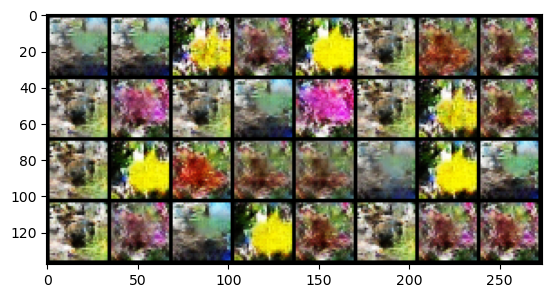

In [40]:
image = mpimg.imread("/kaggle/working/eval_images_900.png")
plt.imshow(image)

In [36]:
gen_model = ACGenerator(nz).apply(initialize_weights)
gen_model.load_state_dict(torch.load('/kaggle/working/ACGen_32_1000_best.pth'))

<All keys matched successfully>

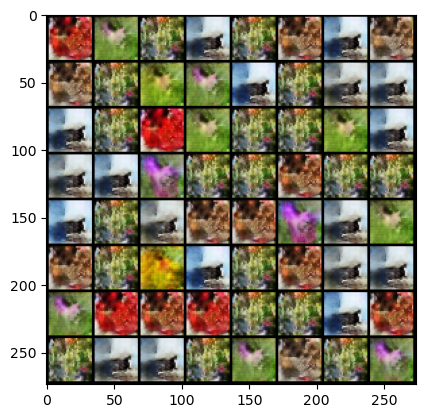

In [37]:
eval_z=torch.randn((64,nz))
eval_class = torch.randint(0,4, (64,))
eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)

with torch.no_grad():
    eval_img = gen_model(eval_z)

    #inverse transform of image
    inv_transform = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2))])
    inv_img=inv_transform(eval_img)
    utils.save_image(inv_img.float(), f"/kaggle/working/generate.png")
    image = mpimg.imread("/kaggle/working/generate.png")
    plt.imshow(image)

In [34]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
def cal_ms_ssim(img_real,img_fake):
    up = nn.Upsample(size=(256,256), mode='bilinear',align_corners=True)
    img_real =up(img_real.type(torch.DoubleTensor))
    img_fake =up(img_fake.type(torch.DoubleTensor))
  
    ms_ssim_module = MS_SSIM(data_range=1,size_average=True,channel=3)
    ms_ssim_score=ms_ssim_module(img_real,img_fake)
    return ms_ssim_score

In [40]:
eval_z=torch.randn((32,nz))
eval_class = torch.randint(0,4, (32,))
eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)
with torch.no_grad():
    eval_img = gen_model(eval_z)
    
pre_img=None
for img, img_class in trainloader:
    img = img.to(device)
    img_class = img_class.to(device)

    if pre_img!=None:
        #ssim_real=cal_ms_ssim((img+1)/2,(pre_img+1)/2)
        #print("real_image",ssim_real)
        ssim_fake=cal_ms_ssim((img+1)/2,(eval_img+1)/2)
        print("fake_image",ssim_fake)
    pre_img=img

fake_image tensor(0.1082, dtype=torch.float64)
fake_image tensor(0.1063, dtype=torch.float64)
fake_image tensor(0.1135, dtype=torch.float64)
fake_image tensor(0.1003, dtype=torch.float64)
fake_image tensor(0.1272, dtype=torch.float64)
fake_image tensor(0.1024, dtype=torch.float64)
fake_image tensor(0.1350, dtype=torch.float64)
fake_image tensor(0.0780, dtype=torch.float64)
fake_image tensor(0.1140, dtype=torch.float64)
fake_image tensor(0.1246, dtype=torch.float64)


KeyboardInterrupt: 

In [39]:
with torch.no_grad():
    eval_z=torch.randn((32,nz))
    eval_class = torch.randint(0,4, (32,))
    eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)
    eval_img1 = gen_model(eval_z)
    
    eval_z=torch.randn((32,nz))
    eval_class = torch.randint(0,4, (32,))
    eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)
    eval_img2 = gen_model(eval_z)
    
    ssim_fake=cal_ms_ssim((eval_img1+1)/2,(eval_img2+1)/2)
    print(ssim_fake)

tensor(0.3834, dtype=torch.float64)
